Goals:
1. Retrieving data from MTA website.
2. Preprocessing the data.
3. Finding the pattern of the foot traffic for the subway stations.
4. Comparing foot traffic among the subway stations.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
%matplotlib inline
from IPython.display import Image

In [3]:
#import data of August(7/29/2017 to 8/25/2017) from mta website
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
week_nums = [170805,170812,170819,170826]
turnstiles_df = get_data(week_nums)

In [4]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/29/2017,00:00:00,REGULAR,6271126,2124514
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/29/2017,04:00:00,REGULAR,6271152,2124520
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/29/2017,08:00:00,REGULAR,6271168,2124549
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/29/2017,12:00:00,REGULAR,6271254,2124604
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/29/2017,16:00:00,REGULAR,6271482,2124653


In [8]:
#extract partial data
turnstiles_df.columns = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES','EXITS']
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE","TIME"], inplace=True)
sample_df = turnstiles_df.iloc[:20000]
sample_df.is_copy = None

1. The Foot traffic of each station for every 4 hours.

In [17]:
dictionary = {}
for name,group in sample_df.groupby(["C/A","UNIT","SCP","STATION"]):
    key = (name)
    value_list = []
    group.apply(lambda x:value_list.append([x.LINENAME, x.DIVISION,x.DATE,x.TIME,x.DESC,x.ENTRIES,x.EXITS]),axis = 1)
    dictionary[key] = value_list
#Partial View of the dictionary
list(dictionary.items())[0:1]

[(('A002', 'R051', '02-00-00', '59 ST'),
  [['NQR456W', 'BMT', '07/29/2017', '00:00:00', 'REGULAR', 6271126, 2124514],
   ['NQR456W', 'BMT', '07/29/2017', '04:00:00', 'REGULAR', 6271152, 2124520],
   ['NQR456W', 'BMT', '07/29/2017', '08:00:00', 'REGULAR', 6271168, 2124549],
   ['NQR456W', 'BMT', '07/29/2017', '12:00:00', 'REGULAR', 6271254, 2124604],
   ['NQR456W', 'BMT', '07/29/2017', '16:00:00', 'REGULAR', 6271482, 2124653],
   ['NQR456W', 'BMT', '07/29/2017', '20:00:00', 'REGULAR', 6271724, 2124686],
   ['NQR456W', 'BMT', '07/30/2017', '00:00:00', 'REGULAR', 6271846, 2124707],
   ['NQR456W', 'BMT', '07/30/2017', '04:00:00', 'REGULAR', 6271861, 2124708],
   ['NQR456W', 'BMT', '07/30/2017', '08:00:00', 'REGULAR', 6271871, 2124722],
   ['NQR456W', 'BMT', '07/30/2017', '12:00:00', 'REGULAR', 6271937, 2124775],
   ['NQR456W', 'BMT', '07/30/2017', '16:00:00', 'REGULAR', 6272086, 2124827],
   ['NQR456W', 'BMT', '07/30/2017', '20:00:00', 'REGULAR', 6272267, 2124868],
   ['NQR456W', 'BMT', '

2.Daily foot traffic of each turnstile.

In [36]:
sample_df[["PREV_DATE","PREV_ENTRIES"]] = (sample_df.groupby(["C/A","UNIT","SCP","STATION"])["DATE","ENTRIES"].
                                           transform(lambda grp:grp.shift(1)))                                  
sample_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
sample_df["Hourly_ENTRIES"] = abs(sample_df["ENTRIES"]-sample_df["PREV_ENTRIES"])
sample_df2 = sample_df.groupby(["C/A","UNIT","SCP","STATION","DATE"]).Hourly_ENTRIES.sum()
sample_df2 = sample_df2.reset_index().rename(columns = {"Hourly_ENTRIES":"Daily_ENTRIES"})
dictionary3 ={}
for name,group in sample_df2.groupby(["C/A","UNIT","SCP","STATION"]):
    key = (name)
    value_list = []
    group.apply(lambda x:value_list.append([time_parser(x.DATE),x.Daily_ENTRIES]),axis = 1)
    dictionary3[key] = value_list
#Partial View of the dictionary
list(dictionary3.items())[0:1]

[(('A002', 'R051', '02-00-00', '59 ST'),
  [[datetime.datetime(2017, 7, 29, 0, 0), 556.0],
   [datetime.datetime(2017, 7, 30, 0, 0), 543.0],
   [datetime.datetime(2017, 7, 31, 0, 0), 1356.0],
   [datetime.datetime(2017, 8, 1, 0, 0), 1471.0],
   [datetime.datetime(2017, 8, 2, 0, 0), 1386.0],
   [datetime.datetime(2017, 8, 3, 0, 0), 1385.0],
   [datetime.datetime(2017, 8, 4, 0, 0), 1370.0]])]

3.Daily foot traffic of a turnstile for a typica week

([<matplotlib.axis.XTick at 0x10ec68e48>,
 <a list of 7 Text xticklabel objects>)

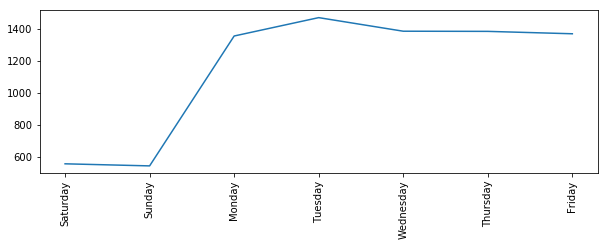

In [37]:
dates = [pd.to_datetime(x) for x in sample_df2.iloc[0:7].DATE.values]
counts = sample_df2["Daily_ENTRIES"][0:7].values
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
labels = ["Saturday","Sunday",'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
plt.xticks(dates, labels, rotation='vertical')

4.Daily Foot traffic info of each stations by adding the foot traffic of all turnstiles

#Daily Foot traffic info of each stations by adding the foot traffic of all turnstiles
sample_df3 = sample_df3.rename(columns = {"C/A":"C_A"})
sample_df4 = sample_df3.groupby(["STATION","DATE"]).Daily_ENTRIES_STATION.sum().reset_index()
dictionary5 = {}
for name,group in sample_df4.groupby("STATION"):
    key = (name)
    value_list = []
    group.apply(lambda x:value_list.append([time_parser(x.DATE),x.Daily_ENTRIES_STATION]),axis = 1)
    dictionary5[key] = value_list
#Partial View of the dictionary
list(dictionary5.items())[0:1]

5.Daily foot traffic of a station for a typica week

In [10]:
Dict_5_val= [x[1] for x in dictionary5["23 ST"]]
dictionary5["14 ST-UNION SQ"][1][0].strftime("%Y-%m-%d")
Dict_5_datetime = [x[0].strftime("%Y-%m-%d") for x in dictionary5["23 ST"]]

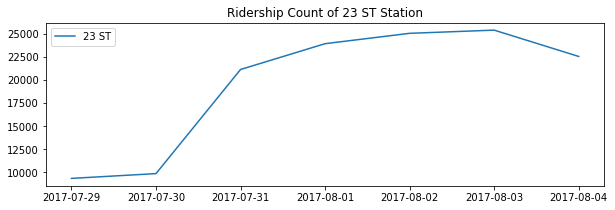

In [11]:
plt.figure(figsize=(10,3))
x_list = range(7)
plt.plot(x_list,Dict_5_val,label = "23 ST")
plt.xticks(x_list, Dict_5_datetime)
plt.legend()
plt.title("Ridership Count of 23 ST Station")

6.Comparing weekly foot traffic for a typical station.

In [29]:
turnstiles_df_1 = turnstiles_df
turnstiles_df_1[["PREV_DATE","PREV_ENTRIES"]] = (turnstiles_df_1.groupby(["C/A","UNIT","SCP","STATION"])["DATE","ENTRIES"].
                                           transform(lambda grp:grp.shift(1)))                                  
turnstiles_df_1.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_df_1["Hourly_ENTRIES"] = abs(turnstiles_df_1["ENTRIES"]-turnstiles_df_1["PREV_ENTRIES"])
turnstiles_df_1 = turnstiles_df_1.groupby(["C/A","UNIT","SCP","STATION","DATE"]).Hourly_ENTRIES.sum()
turnstiles_df_1 = turnstiles_df_1.reset_index().rename(columns = {"Hourly_ENTRIES":"Daily_ENTRIES"})

In [30]:
turnstiles_df_2 = turnstiles_df_1.groupby(["STATION","DATE"]).Daily_ENTRIES.sum().reset_index()
turnstiles_df_2["d_of_week"] = turnstiles_df_2.apply(lambda x:time_parser(x.DATE).weekday(),axis = 1)
sample_2 = turnstiles_df_2[turnstiles_df_2["STATION"] == "1 AV"]
sample_2.is_copy = False

([<matplotlib.axis.XTick at 0x10de4cda0>,
 <a list of 7 Text xticklabel objects>)

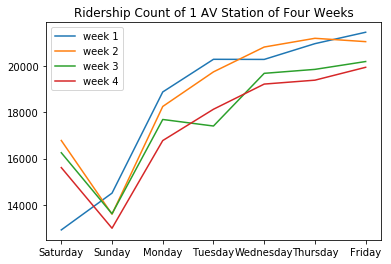

In [31]:
import itertools
temp_list = [[x]*7 for x in range(4)]
sample_2["index_c"] = list(itertools.chain.from_iterable(temp_list))
count = 1
for name, group in sample_2.groupby("index_c"):
    value_list = []
    group.apply(lambda x:value_list.append(x.Daily_ENTRIES),axis=1)
    plt.plot(range(7),value_list)
    plt.legend(["Week %d"%(count)])
    
plt.title("Ridership Count of 1 AV Station of Four Weeks")
plt.legend(["week 1","week 2","week 3","week 4"])
labels = (["Saturday","Sunday",'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.xticks(range(7), labels)

7.Finding the station with the most riderships for over a month.

In [33]:
turnstiles_df_2["formatted_datetime"] = pd.to_datetime(turnstiles_df_2["DATE"],format = "%m/%d/%Y")
turnstiles_df_2["WEEK_NUMBER"]=turnstiles_df_2["formatted_datetime"].dt.week-29
turnstiles_df_4 = turnstiles_df_2.groupby(["WEEK_NUMBER","STATION"]).agg({"Daily_ENTRIES":sum})
turnstiles_df_4 = turnstiles_df_4["Daily_ENTRIES"].groupby(level=0,
                                                           group_keys = False).apply(lambda x:
                                                                    x.sort_values(ascending=False)).reset_index()
turnstiles_df_4["WEEK_NUMBER"].replace(1,"07/29/2017-07/30/2017",inplace = True)
turnstiles_df_4["WEEK_NUMBER"].replace(2,"07/31/2017-08/06/2017",inplace = True)
turnstiles_df_4["WEEK_NUMBER"].replace(3,"07/31/2017-08/06/2017",inplace = True)
turnstiles_df_4["WEEK_NUMBER"].replace(4,"08/14/2017-08/20/2017",inplace = True)
turnstiles_df_4["WEEK_NUMBER"].replace(5,"08/21/2017-08/25/2017",inplace = True)
dictionary7 = {}
for name,group in turnstiles_df_4.groupby("WEEK_NUMBER"):
    key = (name)
    value_list = []
    group.apply(lambda x:value_list.append([x.STATION,x.Daily_ENTRIES]),axis = 1)
    dictionary7[key] = value_list
dictionary7 #final answer

#Find the station with most people over 5 weeks.
turnstiles_df_5 = turnstiles_df_2.groupby(["STATION"]).agg({"Daily_ENTRIES":sum})
turnstiles_df_5.sort_values("Daily_ENTRIES",ascending=False).head()#final answer

,Daily_ENTRIES
STATION,
WALL ST,4.158050e+09
125 ST,2.254531e+09
LEXINGTON AV/63,2.147513e+09
DEKALB AV,1.408072e+09
34 ST-PENN STA,1.215090e+09


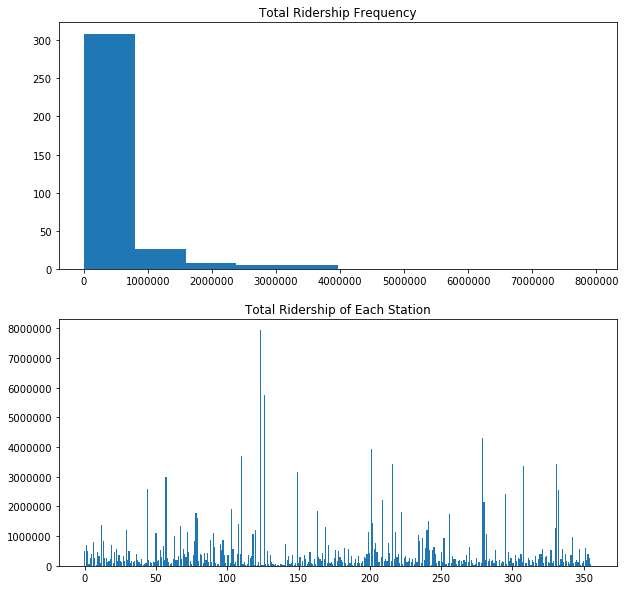

In [34]:
#filtering unreasonable data i.e extremely large or small 
total_rideship_counts = (turnstiles_df_5[(turnstiles_df_5["Daily_ENTRIES"]>1000)
                                         &(turnstiles_df_5["Daily_ENTRIES"]<10000000)]["Daily_ENTRIES"].values)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].hist(total_rideship_counts)
ax[0].set_title("Total Ridership Frequency")

indices = range(len(total_rideship_counts))
ax[1].bar(indices, total_rideship_counts)
ax[1].set_title("Total Ridership of Each Station")